In [1]:
import pandas as pd
import warnings
import re 
from model.bow import BagOfWords
from model.tfidf import TfIdf
import yaml
import matplotlib.pyplot as plt

from utils.preprocessing import *

from konlpy.tag import Okt


warnings.filterwarnings("ignore")

#### Configuration
- 추천 서비스 생성을 위해서 필요한 설정값들을 세팅합니다.

In [2]:
# config
with open('configs/database.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

from utils.query_service import QueryService
query_service = QueryService(cfg['mysql'])

#### Data Import
- 사용할 데이터를 mysql에서 가져옵니다. 

In [3]:
PRODUCT_BOARD_SQL = """
SELECT id
, store_id
, title
, price
, is_soldout
, view 
FROM product_board
"""
product_board = query_service.query_to_pandas_df(PRODUCT_BOARD_SQL)


PRODUCT_SQL = """
SELECT id
, product_board_id
, title as option
, price as option_price
, category
, gluten_free_tag
, high_protein_tag
, sugar_free_tag
, vegan_tag
, ketogenic_tag
FROM product
"""
product = query_service.query_to_pandas_df(PRODUCT_SQL)


REVIEW_SQL = """
SELECT board_id
, badge_taste
, badge_brix
, badge_texture
, rate
, content
FROM review
"""
review = query_service.query_to_pandas_df(REVIEW_SQL)
review = review.drop_duplicates(subset=['board_id', 'content'], keep='first')

#### Preprocessing

1. Product + Product board + Review 데이터 기반 유사도 테이블
2. 평가 방법 3가지 수행 및 시각화
3. 후처리 고려하기

In [4]:
sold_out = product_board[product_board['is_soldout']==1]['store_id'].unique()

In [5]:
grouped = product.groupby('product_board_id').agg({
    'id': 'first',
    'option': ' '.join, # option을 공백을 두고 이어 붙임
    'option_price': 'first',
    'category': 'first',
    'gluten_free_tag': 'first',
    'high_protein_tag': 'first',
    'sugar_free_tag': 'first',
    'vegan_tag': 'first',
    'ketogenic_tag': 'first',
})


df = grouped.copy()
df['id'] = df.index
df.shape


grouped = review.groupby('board_id').agg({
    'rate': 'mean',
    'content': ' '.join  # content을 공백을 두고 이어 붙임
})


df_review = grouped.copy()
df_review['id'] = df_review.index
df_review.shape

(154, 3)

In [6]:
df = df[['id', 'option', 'option_price', 'category', 'gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']].copy()

df['option'] = df['option'].fillna('')
df.loc[df['option'] == '필수상품 없음', 'option'] = ''

In [7]:
# 두 데이터프레임을 store_id (df_board)와 product_board_id (df) 기준으로 병합
merged_df = pd.merge(df, product_board, left_on='id', right_on='id', how='left')
merged_df = pd.merge(merged_df, df_review, left_on = 'id', right_on='id', how='left')
df = merged_df.copy()

In [8]:
# Create the new soup feature
df['title'] = df.apply(create_title, axis=1)

# title에 공백 추가
df['title_with_spaces'], df['title_nouns_list'] = zip(*df['title'].apply(add_spaces))

features = ['gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']

for feature in features:
  df[feature] = df[feature].apply(lambda x: x*feature)


# Removes spaces and converts to lowercase
# Apply the generate_list function to cast, keywords, and director
for feature in ['category', 'gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']:
    df[feature] = df[feature].apply(sanitize)

# Create the new soup feature
df['soup'] = df.apply(create_soup, axis=1)

#### Modeling(CountVec+TF-IDF)

In [9]:
# TfIdfVectorizer 가져오기
from sklearn.feature_extraction.text import TfidfVectorizer

# 불용어를 english로 지정하고 tf-idf 계산
# stop_words='english' 옵션은 영어의 불용어(예: the, and, is 등)를 제외
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['title_with_spaces'])

# Cosine 유사도 계산, overview기반으로 영화간 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_tf = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_tf = pd.DataFrame(cosine_sim_tf, index=df.index, columns=df.index)

cosine_sim_tf.shape


(209, 209)

In [10]:
# Import CountVectorizer from the scikit-learn library
from sklearn.feature_extraction.text import CountVectorizer

# Define a new CountVectorizer object and create vectors for the soup
count = CountVectorizer(stop_words='english')
# 상품*해당 단어가 있는지 카운트 벡터
count_matrix = count.fit_transform(df['soup'])

# Cosine 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_cv = cosine_similarity(count_matrix, count_matrix)
cosine_sim_cv = pd.DataFrame(cosine_sim_cv, index=df.index, columns=df.index)

cosine_sim_cv.shape

(209, 209)

##### 1. Weighted Sum

In [11]:
cosine_sim = cosine_sim_cv*0.3 + cosine_sim_tf*0.7

In [12]:
# Index에 product_board_id 추가
df['product_board_id'] = df['id'].copy()

# index-product_board_id을 뒤집는다
indices = pd.Series(df.index, index=df['product_board_id'])

# 상품제목을 받아서 추천 영화를 돌려주는 함수
def content_recommender(product_board_id, n_of_recomm, sold_out):
    # product_board_id에서 영화 index 받아오기
    idx = indices[product_board_id]
    # 주어진 상품과 다른 상품의 similarity를 가져온다
    sim_scores = cosine_sim[idx]
    # sold_out 후처리
    sim_scores[sold_out] = 0
    # similarity 기준으로 정렬하고 n_of_recomm만큼 가져오기 (자기자신은 빼기)
    sim_scores = sim_scores.sort_values(ascending=False)[1:n_of_recomm+1]
    # 상품 product_board_id 반환
    
    return [df.loc[sim_scores.index]['product_board_id'].values, sim_scores.values, df.loc[sim_scores.index]['store_id'].values]

# 추천받기
print(content_recommender(100, 10, sold_out))

[array([173, 157,  17, 127, 105, 144, 206, 189, 106, 129], dtype=int64), array([0.6764675 , 0.64283396, 0.63601999, 0.61283968, 0.60387011,
       0.58039617, 0.57666447, 0.57511852, 0.57000543, 0.56444166]), array([35, 23, 14,  3, 29, 14, 14, 14, 12,  3], dtype=int64)]


##### 2. Rank Aggration

In [13]:
import numpy as np
final_ranking = (np.argsort(cosine_sim_tf) + np.argsort(cosine_sim_cv)) / 2

final_ranking

array([[191.5,  86.5, 128.5, ...,  93. , 105. ,   0. ],
       [138. ,  73.5,  32. , ...,  23.5, 149. ,  15. ],
       [161. ,  83. ,  30. , ...,  34. , 118. ,  73. ],
       ...,
       [  0. , 134.5, 134.5, ...,  83. , 118.5, 173. ],
       [183. , 109. ,  66.5, ...,  89.5,  35.5, 131. ],
       [ 35. , 160. ,  80.5, ..., 115.5,  64. , 208. ]])

In [14]:
# Index에 product_board_id 추가
df['product_board_id'] = df['id'].copy()

# index-product_board_id을 뒤집는다
indices = pd.Series(df.index, index=df['product_board_id'])

# 상품제목을 받아서 추천 영화를 돌려주는 함수
def content_recommender_rank(product_board_id, n_of_recomm, final_ranking, sold_out):
    # product_board_id에서 영화 index 받아오기
    idx = indices[product_board_id]
    # 주어진 상품과 다른 상품의 similarity를 가져온다
    final_ranking_ = pd.DataFrame(final_ranking)
    final_ranking_ = final_ranking_[idx]
    # sold_out 후처리
    final_ranking_[sold_out] = 0
    # similarity 기준으로 정렬 
    final_ranking_ = final_ranking_.sort_values(ascending=True)[1:n_of_recomm+1]

    # 상품 product_board_id 반환    
    return [df.loc[final_ranking_.index]['product_board_id'].values, final_ranking_.values, df.loc[final_ranking_.index]['store_id'].values]

# 추천받기
print(content_recommender_rank(100, 10, final_ranking, sold_out))

[array([ 77, 112, 102,  74, 137, 132,  32,   9, 140, 178], dtype=int64), array([11. , 19.5, 26. , 28. , 31.5, 39. , 40. , 42. , 43. , 45. ]), array([ 6, 19, 11, 11, 15, 26,  8,  6, 14,  7], dtype=int64)]


#### Evaluation

##### 1. Weighted Sum

##### 1-1. 같은 스토어 상품 추천 비율

In [15]:
# 같은 스토어 상품 추천 개수
recommended_stores = []
recommended_stores_ = []

for i in df.product_board_id.values:
    recommended_stores_ = []
    test = content_recommender(i, 3,sold_out)
    recommended_stores_.extend(test[2])
    recommended_stores.extend([1 for store_id in recommended_stores_ if store_id == i])
    
    
print(sum(recommended_stores)/len(df.product_board_id.values)*3*100,"%")


11.483253588516746 %


##### 1-2. Coverage

In [16]:
recommended_items = []

for i in df.product_board_id.values:
    test = content_recommender(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))

In [17]:
from metrics.coverage import get_coverage

n_items = cosine_sim.shape[0]

get_coverage(recommended_items, n_items)

0.8851674641148325

(array([ 1.,  4.,  5.,  4.,  3.,  6.,  9.,  6.,  5.,  6.,  3., 10., 10.,
         8.,  8.,  7.,  4.,  5.,  6.,  3.,  5.,  4., 11.,  4.,  4.,  5.,
        10.,  8.,  4., 11.,  9.,  6.,  4.,  1.,  8.,  4.,  5., 12.,  9.,
         6.,  6.,  6.,  1.,  6., 14.,  5., 11.,  3.,  3., 14.,  2.,  8.,
         0.,  3.,  2., 10.,  8., 12.,  7.,  8.,  5.,  6.,  4.,  8., 14.,
         4.,  6.,  4.,  5.,  4.,  1.,  6.,  6.,  4., 12.,  7.,  2.,  8.,
         8., 10.,  3.,  5., 14.,  6.,  7., 11.,  5.,  6., 10.,  4., 10.,
         4.,  5.,  3., 10.,  5.,  5.,  4.,  5.,  9.]),
 array([  1.  ,   3.09,   5.18,   7.27,   9.36,  11.45,  13.54,  15.63,
         17.72,  19.81,  21.9 ,  23.99,  26.08,  28.17,  30.26,  32.35,
         34.44,  36.53,  38.62,  40.71,  42.8 ,  44.89,  46.98,  49.07,
         51.16,  53.25,  55.34,  57.43,  59.52,  61.61,  63.7 ,  65.79,
         67.88,  69.97,  72.06,  74.15,  76.24,  78.33,  80.42,  82.51,
         84.6 ,  86.69,  88.78,  90.87,  92.96,  95.05,  97.14,  99.23,
  

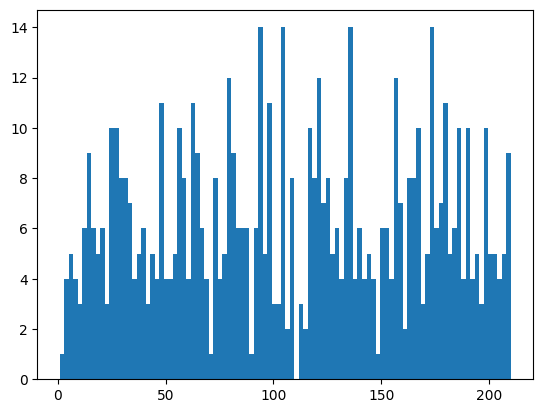

In [18]:
plt.hist(recommended_items, bins = 100)

##### 1-3. 추천 상품출력 → 유사한지 확인

In [19]:
case_1, _, _ = content_recommender(10, 3, sold_out)

df.loc[df['product_board_id'].isin(case_1), ["product_board_id", "title_with_spaces", "category", "soup"]]

,product_board_id,title_with_spaces,category,soup
24,25,딸기 다이어트 설탕 베이글 크림 블루베리 저당 식빵,etc,etc ketogenic_tag
68,69,딸기 버터 다이어트 설탕 번 젤리 저당 꿀맛 식빵,etc,etc ketogenic_tag
171,174,딸기 버터 다이어트 설탕 비건 크림 저당 스콘 식빵,etc,etc high_protein_tag sugar_free_tag vegan_tag


In [20]:
case_2, _, _ = content_recommender(70, 3, sold_out)

df.loc[df['product_board_id'].isin(case_2), ["product_board_id", "title_with_spaces", "category", "soup"]]

,product_board_id,title_with_spaces,category,soup
97,98,비건 식빵,bread,bread vegan_tag
124,125,비건 버터 식빵,bread,bread gluten_free_tag vegan_tag
167,170,다이어트 번 말차 비건 크림 초코 블루베리 쿠키,etc,etc gluten_free_tag


In [21]:
case_3, _, _ = content_recommender(100, 3, sold_out)
df.loc[df['product_board_id'].isin(case_3), ["product_board_id", "title_with_spaces", "category", "soup"]]

,product_board_id,title_with_spaces,category,soup
16,17,쿠키 피칸 비건 카라멜,cookie,cookie gluten_free_tag vegan_tag
155,157,코코넛 무화과 다이어트 유자 아몬드 말차 비건 쿠키 얼그레이 초코 쑥 스콘 마들렌 파운드,etc,etc gluten_free_tag vegan_tag
170,173,버터 코코넛 무화과 아몬드 헤이즐넛 말차 비건 얼그레이 초코 레몬 쑥 스콘 쿠키 단호박,cookie,cookie gluten_free_tag vegan_tag


##### 2. Rank Aggregation

##### 2-1. 같은 스토어 상품 추천 비율

In [22]:
# 같은 스토어 상품 추천 개수
recommended_stores = []
recommended_stores_ = []

for i in df.product_board_id.values:
    recommended_stores_ = []
    test = content_recommender_rank(i, 3, final_ranking,sold_out)
    recommended_stores_.extend(test[2])
    recommended_stores.extend([1 for store_id in recommended_stores_ if store_id == i])
    
    
print(sum(recommended_stores)/len(df.product_board_id.values)*3*100,"%")


1.4354066985645932 %


##### 2-2. Coverage

In [23]:
recommended_items = []

for i in df.product_board_id.values:
    test = content_recommender_rank(i, 3, final_ranking, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))

In [24]:
from metrics.coverage import get_coverage

n_items = cosine_sim.shape[0]

get_coverage(recommended_items, n_items)

0.9043062200956937

(array([ 5.,  9.,  4.,  8.,  6.,  6.,  3., 10.,  4.,  5.,  9.,  4.,  5.,
         8.,  9.,  9.,  8.,  6.,  7.,  9., 11.,  2.,  8.,  8.,  2.,  3.,
         6.,  8.,  6., 11., 10.,  8.,  5.,  7.,  3.,  1.,  7.,  9.,  8.,
         6.,  4.,  7.,  9.,  4.,  2.,  9.,  5.,  3.,  8.,  5., 14.,  9.,
         7.,  3.,  2.,  8.,  9.,  4.,  7.,  3.,  8.,  6.,  5.,  4.,  7.,
         8.,  6.,  7.,  7.,  4., 11.,  1.,  8.,  2.,  8.,  2.,  4.,  6.,
         6.,  1.,  7.,  5.,  9., 10., 12., 12.,  4.,  7.,  4.,  3.,  8.,
         5.,  2.,  6.,  5., 10.,  9.,  3.,  6.,  4.]),
 array([  1. ,   3.1,   5.2,   7.3,   9.4,  11.5,  13.6,  15.7,  17.8,
         19.9,  22. ,  24.1,  26.2,  28.3,  30.4,  32.5,  34.6,  36.7,
         38.8,  40.9,  43. ,  45.1,  47.2,  49.3,  51.4,  53.5,  55.6,
         57.7,  59.8,  61.9,  64. ,  66.1,  68.2,  70.3,  72.4,  74.5,
         76.6,  78.7,  80.8,  82.9,  85. ,  87.1,  89.2,  91.3,  93.4,
         95.5,  97.6,  99.7, 101.8, 103.9, 106. , 108.1, 110.2, 112.3,
        

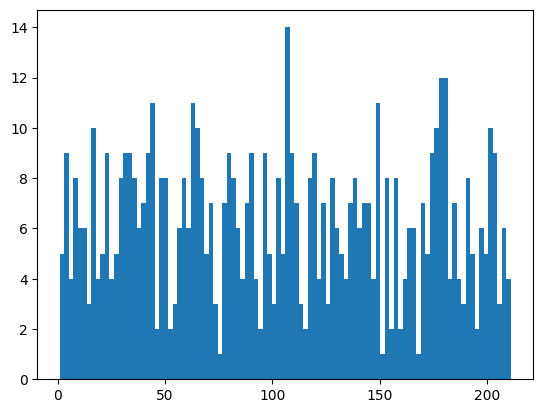

In [25]:
plt.hist(recommended_items, bins = 100)

##### 2-3. 추천 상품출력 → 유사한지 확인

In [26]:
case_1, _, _ = content_recommender_rank(10, 3, final_ranking, sold_out)

df.loc[df['product_board_id'].isin(case_1), ["product_board_id", "title_with_spaces", "category", "soup"]]

,product_board_id,title_with_spaces,category,soup
30,31,다이어트 버터 피칸 스콘 브라우니 아몬드 말차 바나나 크루아상 비건 얼그레이 초코 ...,cookie,cookie gluten_free_tag vegan_tag
170,173,버터 코코넛 무화과 아몬드 헤이즐넛 말차 비건 얼그레이 초코 레몬 쑥 스콘 쿠키 단호박,cookie,cookie gluten_free_tag vegan_tag
184,187,비건 설탕 아몬드,cookie,cookie gluten_free_tag vegan_tag


In [27]:
case_2, _, _ = content_recommender(70, 3, sold_out)

df.loc[df['product_board_id'].isin(case_2), ["product_board_id", "title_with_spaces", "category", "soup"]]

,product_board_id,title_with_spaces,category,soup
97,98,비건 식빵,bread,bread vegan_tag
124,125,비건 버터 식빵,bread,bread gluten_free_tag vegan_tag
167,170,다이어트 번 말차 비건 크림 초코 블루베리 쿠키,etc,etc gluten_free_tag


In [28]:
case_3, _, _ = content_recommender(100, 3, sold_out)
df.loc[df['product_board_id'].isin(case_3), ["product_board_id", "title_with_spaces", "category", "soup"]]

,product_board_id,title_with_spaces,category,soup
16,17,쿠키 피칸 비건 카라멜,cookie,cookie gluten_free_tag vegan_tag
155,157,코코넛 무화과 다이어트 유자 아몬드 말차 비건 쿠키 얼그레이 초코 쑥 스콘 마들렌 파운드,etc,etc gluten_free_tag vegan_tag
170,173,버터 코코넛 무화과 아몬드 헤이즐넛 말차 비건 얼그레이 초코 레몬 쑥 스콘 쿠키 단호박,cookie,cookie gluten_free_tag vegan_tag


### Save

In [29]:
import pandas as pd
from datetime import datetime

In [ ]:

query_item = df.index.values.repeat(3)

recommended_items = []

for i in df.product_board_id.values:
    test = content_recommender_rank(i, 3, final_ranking, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))


score = []

for i in df.product_board_id.values:
    test = content_recommender_rank(i, 3, final_ranking, sold_out)
    score.extend(test[1])


score = list(map(lambda x: float(x), score))


rank = [1, 2, 3]*cosine_sim.shape[0]

recommendation_theme = ['similarity']*cosine_sim.shape[0]*3

model_version = ['bow-1+TF-IDF']*cosine_sim.shape[0]*3

created_at = [datetime.now()]*cosine_sim.shape[0]*3

modified_at = [datetime.now()]*cosine_sim.shape[0]*3

In [37]:
import pandas as pd
from datetime import datetime
data = {
    'query_item': query_item,
    'recommendation_item': recommended_items,
    'score': score,
    'rank': rank,
    'recommendation_theme': recommendation_theme,
    'model_version': model_version,
    'created_at': created_at,
    'modified_at': modified_at
}

recommendation_df = pd.DataFrame(data)


In [38]:
recommendation_df

,query_item,recommendation_item,score,rank,recommendation_theme,model_version,created_at,modified_at
0,0,177,0.584421,1,similarity,bow-1+TF-IDF,2024-11-07 20:53:36.776393,2024-11-07 20:53:36.776393
1,0,40,0.533055,2,similarity,bow-1+TF-IDF,2024-11-07 20:53:36.776393,2024-11-07 20:53:36.776393
2,0,175,0.530891,3,similarity,bow-1+TF-IDF,2024-11-07 20:53:36.776393,2024-11-07 20:53:36.776393
3,1,31,0.615057,1,similarity,bow-1+TF-IDF,2024-11-07 20:53:36.776393,2024-11-07 20:53:36.776393
4,1,65,0.566127,2,similarity,bow-1+TF-IDF,2024-11-07 20:53:36.776393,2024-11-07 20:53:36.776393
...,...,...,...,...,...,...,...,...
622,207,85,0.686496,2,similarity,bow-1+TF-IDF,2024-11-07 20:53:36.776393,2024-11-07 20:53:36.776393
623,207,88,0.685369,3,similarity,bow-1+TF-IDF,2024-11-07 20:53:36.776393,2024-11-07 20:53:36.776393
624,208,26,0.466413,1,similarity,bow-1+TF-IDF,2024-11-07 20:53:36.776393,2024-11-07 20:53:36.776393
625,208,158,0.435872,2,similarity,bow-1+TF-IDF,2024-11-07 20:53:36.776393,2024-11-07 20:53:36.776393


(array([  2.,  24.,   7.,  26.,  86., 162., 141.,  65.,  72.,  42.]),
 array([0.14516413, 0.23064772, 0.3161313 , 0.40161489, 0.48709848,
        0.57258207, 0.65806565, 0.74354924, 0.82903283, 0.91451641,
        1.        ]),
 <BarContainer object of 10 artists>)

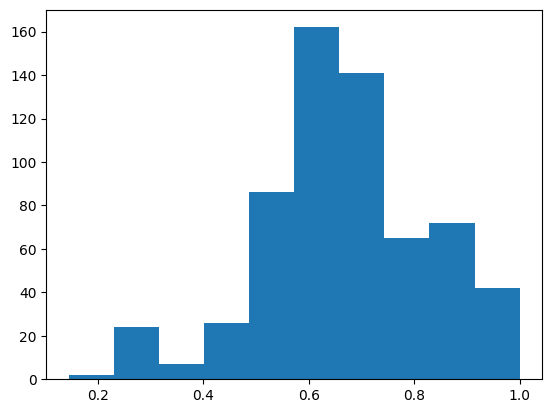

In [39]:
plt.hist(recommendation_df['score'])

(array([ 5.,  9.,  4.,  8.,  6.,  6.,  3., 10.,  4.,  5.,  9.,  4.,  5.,
         8.,  9.,  9.,  8.,  6.,  7.,  9., 11.,  2.,  8.,  8.,  2.,  3.,
         6.,  8.,  6., 11., 10.,  8.,  5.,  7.,  3.,  1.,  7.,  9.,  8.,
         6.,  4.,  7.,  9.,  4.,  2.,  9.,  5.,  3.,  8.,  5., 14.,  9.,
         7.,  3.,  2.,  8.,  9.,  4.,  7.,  3.,  8.,  6.,  5.,  4.,  7.,
         8.,  6.,  7.,  7.,  4., 11.,  1.,  8.,  2.,  8.,  2.,  4.,  6.,
         6.,  1.,  7.,  5.,  9., 10., 12., 12.,  4.,  7.,  4.,  3.,  8.,
         5.,  2.,  6.,  5., 10.,  9.,  3.,  6.,  4.]),
 array([  1. ,   3.1,   5.2,   7.3,   9.4,  11.5,  13.6,  15.7,  17.8,
         19.9,  22. ,  24.1,  26.2,  28.3,  30.4,  32.5,  34.6,  36.7,
         38.8,  40.9,  43. ,  45.1,  47.2,  49.3,  51.4,  53.5,  55.6,
         57.7,  59.8,  61.9,  64. ,  66.1,  68.2,  70.3,  72.4,  74.5,
         76.6,  78.7,  80.8,  82.9,  85. ,  87.1,  89.2,  91.3,  93.4,
         95.5,  97.6,  99.7, 101.8, 103.9, 106. , 108.1, 110.2, 112.3,
        

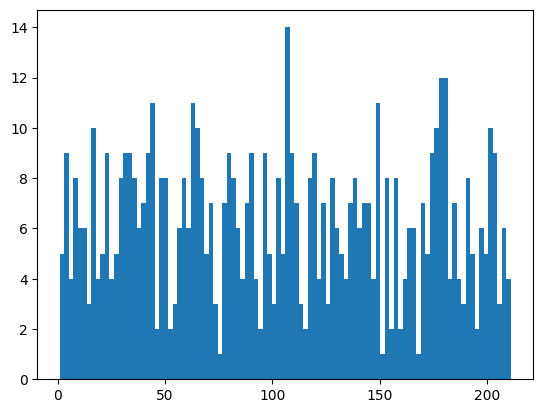

In [34]:
plt.hist(recommendation_df['recommendation_item'], bins = 100)